This notebok benchmarks different simple stencils (pointwise, 1D, etc.) using pure python code (lists), numpy arrays keeping `for` loops, and numpy parallel code.

In [1]:
import sys
import random
import math
import timeit
import numpy as np

In [2]:
from common import initialize_fields, plot_field

In [3]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

# Pointwise stencils

We consider two pointwise stencil models: a simple copy, and applying the `sin` function.

$$
a(i) = b(i)
$$

$$
a(i) = \sin(b(i))
$$

### Nested lists and `for` loops

In [4]:
def list_pointwise(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k][j][i] = in_field[k][j][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

Before running the first benchmark, let's have a look at how Python lists are stored in memory.

Python lists are quite big objects. Under the hood, the CPython implementation of the list object is a vector of pointers, so each element of a list is by itself a proper Python object and a pointer to it is what is stored in the list object. Essentially, after removing some comments, the implementation that can be found in [listobject.h](https://github.com/python/cpython/blob/main/Include/cpython/listobject.h) is the following:

```C
typedef struct {
    PyObject_VAR_HEAD
    PyObject **ob_item;
    Py_ssize_t allocated;
} PyListObject;
```

So our 3D fields are in fact a list containing 80 lists (dimension Z), each of these lists containing 128 lists (dimension Y), and finally each of these lists containing 128 floats. Python lists can be enlarge, reduced, and new elements can be inserted or deleted at arbitrary positions. All these make these objects extremely cache unfriendly. When accessing the field element (x,y,z) with `field[z][y][x]` a bunch of pointers have to be followed, and therefore the chances that subsequent values remain in the cache are minimal.

In [5]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_pointwise(in_field, out_field)

8.25 s ± 9.46 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Even though Python lists are not ideal to maximize cache hits, it is still expected to see a difference depending on the order of the `for` loops. Let's verify this trying all the possible permutations: ZYX (done above), XYZ, XZY, ZXY, YXZ, YZX.

In [6]:
def list_pointwise_XYZ(in_field, out_field):
    for n in range(N_ITER):
        for i in range(NX):
            for j in range(NY):
                for k in range(NZ):
                    out_field[k][j][i] = in_field[k][j][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def list_pointwise_XZY(in_field, out_field):
    for n in range(N_ITER):
        for i in range(NX):
            for k in range(NZ):
                for j in range(NY):
                    out_field[k][j][i] = in_field[k][j][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def list_pointwise_ZXY(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for i in range(NX):
                for j in range(NY):
                    out_field[k][j][i] = in_field[k][j][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def list_pointwise_YXZ(in_field, out_field, plot=False):
    for n in range(N_ITER):
        for j in range(NY):
            for i in range(NX):
                for k in range(NZ):
                    out_field[k][j][i] = in_field[k][j][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field


def list_pointwise_YZX(in_field, out_field):
    for n in range(N_ITER):
        for j in range(NY):
            for k in range(NZ):
                for i in range(NX):
                    out_field[k][j][i] = in_field[k][j][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [7]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_pointwise_XYZ(in_field, out_field)

15 s ± 9.18 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [8]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_pointwise_XZY(in_field, out_field)

11.8 s ± 133 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [9]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_pointwise_ZXY(in_field, out_field)

9.92 s ± 254 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [10]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_pointwise_YXZ(in_field, out_field)

12.2 s ± 75.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [11]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_pointwise_YZX(in_field, out_field)

8.72 s ± 36.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Clearly, by looking at these times, with nested lists we should iterate in the same order as we have nested the lists, i.e., the first level should be looped the slowest, and the innermost level should be looped the fastest. The explanation for this is that to access the element `field[k][j][i+1]` the information (pointers) required to access the innermost list, i.e., `field[k][j]`, is already in the cache, while to get `field[i+1][j][k]` we have to follow a whole new path of pointers, which most likely are not in the cache if the list is large enough.

Furthermore, we would expect that if the fields are initialized with the same order of the nested lists as the loop order, we should obtain similar performance. Let's check this for the cases XYZ and YZX.

In [12]:
def list_pointwise_XYZ_alt(in_field, out_field):
    for n in range(N_ITER):
        for i in range(NX):
            for j in range(NY):
                for k in range(NZ):
                    out_field[i][j][k] = in_field[i][j][k]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def list_pointwise_YZX_alt(in_field, out_field):
    for n in range(N_ITER):
        for j in range(NY):
            for k in range(NZ):
                for i in range(NX):
                    out_field[j][k][i] = in_field[j][k][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [13]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, dim_order="XYZ", mode="square"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_pointwise_XYZ_alt(in_field, out_field)

8.4 s ± 3.77 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [14]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, dim_order="YZX", mode="square"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_pointwise_YZX_alt(in_field, out_field)

8.29 s ± 25.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Similarly, we could replicate the worst results by using the opposite list structure to the loop order. Let's try this with the two best results from above: ZYX and and YZX.

In [15]:
def list_pointwise_ZYX_alt(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[i][j][k] = in_field[i][j][k]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def list_pointwise_YZX_alt(in_field, out_field):
    for n in range(N_ITER):
        for j in range(NY):
            for k in range(NZ):
                for i in range(NX):
                    out_field[i][k][j] = in_field[i][k][j]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [16]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, dim_order="XYZ", mode="square"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_pointwise_ZYX_alt(in_field, out_field)

16 s ± 115 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [17]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, dim_order="XZY", mode="square"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_pointwise_YZX_alt(in_field, out_field)

16.6 s ± 241 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


All these results confirm our previous explanation.

Let's now check the other simple pointwise stencil computation. In this case, instead of just copying all the values, we will compute the sine of each gridpoint.

In [18]:
def list_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    # numpy.sin() is ~7 times slower than math.sin() when applied to single values
                    # Check Appendix for more details about this.
                    out_field[k][j][i] = math.sin(in_field[k][j][i])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [19]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_sin_pointwise(in_field, out_field)

13.5 s ± 107 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


### NumPy arrays and `for` loops

The following code will show the worst we can do when trying to work with NumPy arrays. Surprisingly, as we will see in [the Numba notebook](./2_numba.ipynb), this way of working with NumPy arrays is neccesary when working with certain accelerators.

In [20]:
def array_pointwise(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [21]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_pointwise(in_field, out_field)

15 s ± 2.45 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


However, it is still interesting to try all the possible permutations of the `for` loops. Hopefully, this will give us some hints to how NumPy arrays are stored in memory.

In [22]:
def array_pointwise_ZYX(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def array_pointwise_XYZ(in_field, out_field):
    for n in range(N_ITER):
        for i in range(NX):
            for j in range(NY):
                for k in range(NZ):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def array_pointwise_XZY(in_field, out_field):
    for n in range(N_ITER):
        for i in range(NX):
            for k in range(NZ):
                for j in range(NY):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
            
def array_pointwise_ZXY(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for i in range(NX):
                for j in range(NY):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
            
def array_pointwise_YXZ(in_field, out_field):
    for n in range(N_ITER):
        for j in range(NY):
            for i in range(NX):
                for k in range(NZ):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def array_pointwise_YZX(in_field, out_field):
    for n in range(N_ITER):
        for j in range(NY):
            for k in range(NZ):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [23]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_pointwise_ZYX(in_field, out_field)

15.1 s ± 80 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [24]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_pointwise_XYZ(in_field, out_field)

15.5 s ± 22.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [25]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_pointwise_XZY(in_field, out_field)

15.2 s ± 10.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [26]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_pointwise_ZXY(in_field, out_field)

15.1 s ± 6.27 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_pointwise_YXZ(in_field, out_field)

15.5 s ± 11 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [28]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_pointwise_YZX(in_field, out_field)

15.1 s ± 9.18 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


**TODO: Add interpretation**

Now let's run the benchmark for the `sin()` stencil.

In [29]:
def array_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = math.sin(in_field[k, j, i])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [30]:
%%timeit -n1 -r3 in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_sin_pointwise(in_field, out_field)

21.6 s ± 5.07 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


### NumPy arrays with vectorized code

Now we test the performance of the same two pointwise stencils using the vectorized NumPy that does not use `for` loops to iterate over the three spatial dimensions.

In [31]:
def numpy_pointwise(in_field, out_field):
    for n in range(N_ITER):
        out_field[:, :, :] = in_field[:, :, :]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [32]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
numpy_pointwise(in_field, out_field)

35.1 ms ± 42.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
def numpy_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        out_field = np.sin(in_field)
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [34]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
numpy_sin_pointwise(in_field, out_field)

391 ms ± 3.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The conclusion of these first tests is that Python loops are **terribly slow**. Python lists are not cache friendly but they are surprisingly fast if one takes into account how flexible they are. NumPy arrays can make things worse if they are used incorrectly, e.g., by iterating over the arrays. However, when used correctly, i.e., writing vectorized code, we can increase a lot the performance. The simplest pointwise stencil (copy) using NumPy vectorized code is **~150x faster** than pure Python code with lists, and the pointwise stencil applying `sin()` is **~7x faster**.

# 1D stencils

1D stencils updating with values from the same row or same colum only and with periodic boundary conditions.

$$
a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]
$$

$$
a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]
$$

The factor 1/2 is to avoid getting huge numbers when `N_ITER` is large with the simple initialization patterns we defined before.

**TODO: Redo this part with the optimal shapes of the lists. We should not care about NumPy array order in this section because we are converting them to lists. The relevant part here is the order of the nested lists. In the NumPy part we should explore the differences between C-order and Fortran-order.**

###  Same column: $a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]$

In [35]:
def list_1D_same_col_ZXY(in_field, out_field, plot=False):
    for n in range(N_ITER):
        for k in range(NZ):
            for i in range(NX - 1):
                for j in range(NY):
                    out_field[k][j][i] = 0.5 * (in_field[k][j][i+1] - in_field[k][j][i])
                    # Periodic boundary condition
                    out_field[k][j][NX-1] = 0.5 * (in_field[k][j][0] - in_field[k][j][NX-1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

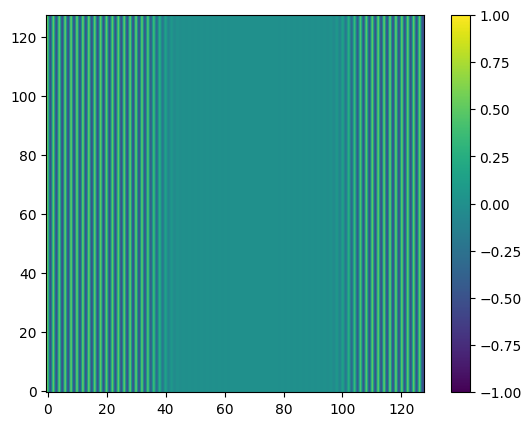

In [36]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
in_field = in_field.tolist()
out_field = out_field.tolist()
list_1D_same_col_row_update(in_field, out_field, plot=True);

In [37]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_1D_same_col_row_update(in_field, out_field)

36.2 s ± 209 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
def list_1D_same_col_col_update(in_field, out_field, plot=False):
    # Apply 1D stencil
    tic = timeit.default_timer()
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX - 1):
                    out_field[k][j][i] = 0.5 * (in_field[k][j][i+1] - in_field[k][j][i])
                out_field[k][j][NX-1] = 0.5 * (in_field[k][j][0] - in_field[k][j][NX-1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)
        
    return toc - tic

In [39]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_1D_same_col_col_update(in_field, out_field)

15 s ± 365 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


If our stencil update only uses values from the same row, we should loop the field row-wise to maximize the cache hits. Working with python lists the performance difference is very noticeable.

In [40]:
def array_1D_same_col_row_update(in_field, out_field, plot=False):
    # Apply 1D stencil
    tic = timeit.default_timer()
    
    for n in range(N_ITER):
        for k in range(NZ):
            for i in range(NX - 1):
                for j in range(NY):
                    out_field[k, j, i] = 0.5 * (in_field[k, j, i+1] - in_field[k, j, i])
                    # Periodic boundary condition
                    out_field[k, j, NX-1] = 0.5 * (in_field[k, j, 0] - in_field[k, j, NX-1])
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)
        
    return toc - tic

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
array_1D_same_col_row_update(in_field, out_field)

In [ ]:
def array_1D_same_col_col_update(in_field, out_field, plot=False):
    # Apply 1D stencil
    tic = timeit.default_timer()
    
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX - 1):
                    out_field[k, j, i] = 0.5 * (in_field[k, j, i+1] - in_field[k, j, i])
                    # Periodic boundary condition
                out_field[k, j, NX-1] = 0.5 * (in_field[k, j, 0] - in_field[k, j, NX-1])
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)
        
    return toc - tic

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
array_1D_same_col_col_update(in_field, out_field)

In [ ]:
def numpy_1D_same_col(in_field, out_field, plot=False):    
    # Apply 1D stencil
    tic = timeit.default_timer()
    for n in range(N_ITER):
        out_field[:, :, :-1] = 0.5 * (in_field[:, :, 1:] - in_field[:, :, :-1])
        # Periodic boundary condition
        out_field[:, :, -1] = 0.5 * (in_field[:, :, 0] - in_field[:, :, -1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)

    return toc - tic

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars", order="C")
numpy_1D_same_col(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars", order="F")
numpy_1D_same_col(in_field, out_field)

By default, NumPy arrays are stored row-wise (C style) in the data buffer, but this can be changed using the argument `order`. That is why we see a performance increase if we explicitly initialized the fields col-wise (Fortran style).

## Same row: $a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]$

In [ ]:
def list_1D_same_row_row_update(in_field, out_field, plot=False):
    # Apply 1D stencil
    tic = timeit.default_timer()
    for n in range(N_ITER):
        for k in range(NZ):
            for i in range(NX):
                for j in range(NY-1):
                    out_field[k][j][i] = 0.5 * (in_field[k][j+1][i] - in_field[k][j][i])
                out_field[k][NY-1][i] = 0.5 * (in_field[k][0][i] - in_field[k][NY-1][i])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)
        
    return toc - tic

In [ ]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars", order="C")
in_field = in_field.tolist()
out_field = out_field.tolist()
list_1D_same_row_row_update(in_field, out_field, plot=True);

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars", order="C"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_1D_same_row_row_update(in_field, out_field)

In [ ]:
def list_1D_same_row_col_update(in_field, out_field, plot=False):
    # Apply 1D stencil
    tic = timeit.default_timer()
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY-1):
                for i in range(NX):
                    out_field[k][j][i] = 0.5 * (in_field[k][j+1][i] - in_field[k][j][i])
                    out_field[k][NY-1][i] = 0.5 * (in_field[k][0][i] - in_field[k][NY-1][i])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)
        
    return toc - tic

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars", order="C"); in_field = in_field.tolist(); out_field = out_field.tolist()
list_1D_same_row_col_update(in_field.tolist(), out_field.tolist())

Similary, if our stencil update only uses values from the same col, we should loop the field col-wise to benefit from the cache.

In [ ]:
def array_1D_same_row_row_update(in_field, out_field, plot=False):
    # Apply 1D stencil
    tic = timeit.default_timer()
    for n in range(N_ITER):
        for k in range(NZ):
            for i in range(NX):
                for j in range(NY-1):
                    out_field[k, j, i] = 0.5 * (in_field[k, j+1, i] - in_field[k, j, i])
                out_field[k, NY-1, i] = 0.5 * (in_field[k, 0, i] - in_field[k, NY-1, i])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)
        
    return toc - tic

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
array_1D_same_row_row_update(in_field, out_field)

In [ ]:
def array_1D_same_row_col_update(in_field, out_field, plot=False):
    tic = timeit.default_timer()

    # Apply 1D stencil
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY - 1):
                for i in range(NX):
                    out_field[k, j, i] = 0.5 * (in_field[k, j+1, i] - in_field[k, j, i])
                    out_field[k, NY-1, i] = 0.5 * (in_field[k, 0, i] - in_field[k, NY-1, i])
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)
        
    return toc - tic

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
array_1D_same_row_col_update(in_field, out_field)

In [ ]:
def numpy_1D_same_row(in_field, out_field, plot=False):    
    # Apply 1D stencil
    tic = timeit.default_timer()
    for n in range(N_ITER):
        out_field[:, :-1, :] = 0.5 * (in_field[:, 1:, :] - in_field[:, :-1, :])
        # Periodic boundary condition
        out_field[:, -1, :] = 0.5 * (in_field[:, 0, :] - in_field[:, -1, :])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    toc = timeit.default_timer()

    if plot:
        plot_field(out_field)

    return toc - tic

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars", order="C")
numpy_1D_same_row(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars", order="F")
numpy_1D_same_row(in_field, out_field)

The reasons why we don't observe a difference in this case is because the C-order and Fortran-order affect all dimensions of the array not just the XY dimensions as it would happen in a 2D field. For multidimensional arrays it is more convenient to think which index is changing more rapidly and more slowly when moving through contigous elements in the data buffer. In the case of C-order arrays, the last index changes most rapidly, while in Fortran-order arrays the first does.

## 2D stencil

The last stencil we will check is the 4th-order non-monotonic diffusion we used during the course, which is defined in terms of the Laplace operator as

$$
a(i, j) = \Delta(\Delta(b(i, j)))
$$

Since it is already clear from the experiments with pointwise and 1D stencils, that python `for` loops are very slow. Here we will only run the numpy implementation from `stencil2d.py` given in the course. This will set the base time to improve using the different high-level programming techniques available in Python (which will be tested in different notebooks).

In [ ]:
from stencil2d import apply_diffusion as numpy_2D

In [ ]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
plot_field(in_field)

In [ ]:
numpy_2D(in_field, out_field, num_halo=2, num_iter=N_ITER)

In [ ]:
plot_field(out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
numpy_2D(in_field, out_field, num_halo=2, num_iter=N_ITER)

# Conclusions

- NumPy arrays are much faster than Python lists
- The explanation is that (vectorized) NumPy code is much more cache friendly than Python code with nested `for` loops
- **TODO: Verify this carefully.** Unfortunately, NumPy does not take full advantage of multithreading
- NumPy is not very efficient about memory usage (there are some exceptions such as matrix-matrix multiplication)

---

# Appendices

## np.sin() vs math.sin()

There is no doubt that `np.sin()` is faster than `math.sin()` when applied to large NumPy arrays. But this function has an overhead cost when applied to single elements. Here we show that `math.sin()` is more efficient than `np.sin()` when applied to 4 or less elements. However, the overhead of a Python loop is even worse than the overhead of `np.sin()`.

In [ ]:
rng = np.random.default_rng()
x = rng.random(100)

`np.sin()` is ~7.7 times slower than `math.sin()` when applied to a single value.

In [ ]:
%timeit math.sin(x[0])

In [ ]:
%timeit np.sin(x[0])

However, we loose part of this performance the moment we use a single for loop.

In [ ]:
%timeit for i in range(1): math.sin(x[i])

In [ ]:
%timeit np.sin(x[:1])

In any case, even without for loops, `math.sin()` becomes slower than `np.sin()` the moment we need to compute more than four values.

In [ ]:
%timeit math.sin(x[0]), math.sin(x[1]), math.sin(x[2]), math.sin(x[3]), math.sin(x[4]), math.sin(x[5])

In [ ]:
%timeit np.sin(x[:6])

This is because `np.sin()` computes these values in parallel, while the `math.sin()` computes them sequentially.

## Different dtypes affect performance

NumPy supports defines different data type (dtype) objects which describes how the bytes in the fixed-size block of memory corresponding to an array item should be interpreted. By default, NumPy will choose a proper dtype depending on the input passing to the constructor. However, we are free to change this default behaviour by specifying manually the dtype. As expected, and quickly demonstrated here using the `numpy_sin_pointwise()` function, this choice can also impact the performance of our stencil model.

In [ ]:
dtypes_ = [np.float16, np.float32, np.float64, np.float128]

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", dtype=dtypes_[0])
numpy_sin_pointwise(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", dtype=dtypes_[1])
numpy_sin_pointwise(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", dtype=dtypes_[2])
numpy_sin_pointwise(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", dtype=dtypes_[3])
numpy_sin_pointwise(in_field, out_field)

More numerical precision implies moving more data from and to memory.

## NumPy arrays in detail

NumPy arrays have two parts: a data buffer and a metadata block containing all the relevant information to correctly interpret the data buffer. Many changes to an array (e.g. transposing or slicing) can leave the data buffer unmodified and just modify the metadata. Understanding how data is stored is crucial to understand and optimize NumPy code. For example, we might think that certain values are close to each other in memory based on the shape or the array, but maybe this is just an artifact of how the array is interpreted with its current metadata.

In [ ]:
def array_pointwise_loop_ZYX(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
            
def array_pointwise_loop_XZY(in_field, out_field):
    for n in range(N_ITER):
        for i in range(NX):
            for k in range(NZ):
                for j in range(NY):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def array_pointwise_loop_YXZ(in_field, out_field):
    for n in range(N_ITER):
        for j in range(NY):
            for i in range(NX):
                for k in range(NZ):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
            
def array_pointwise_loop_XYZ(in_field, out_field):
    for n in range(N_ITER):
        for i in range(NX):
            for j in range(NY):
                for k in range(NZ):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def array_pointwise_loop_ZXY(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for i in range(NX):
                for j in range(NY):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def array_pointwise_loop_YZX(in_field, out_field):
    for n in range(N_ITER):
        for j in range(NY):
            for k in range(NZ):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_pointwise_loop_ZYX(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_pointwise_loop_XZY(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_pointwise_loop_YXZ(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_pointwise_loop_XYZ(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_pointwise_loop_ZXY(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_pointwise_loop_YZX(in_field, out_field)

It seems that the order of the `for` loops have very little impact. Let's check what happens if we changes from C-order to Fortran-order arrays.

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", array_order="F")
array_pointwise_loop_ZYX(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", array_order="F")
array_pointwise_loop_XZY(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", array_order="F")
array_pointwise_loop_YXZ(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", array_order="F")
array_pointwise_loop_XYZ(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", array_order="F")
array_pointwise_loop_ZXY(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", array_order="F")
array_pointwise_loop_YZX(in_field, out_field)

Also, little or no differences at all. Lastly, let's check the impact of different array shapes with a fix loop order.

In [ ]:
def array_pointwise_access_ZYX(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
            
def array_pointwise_access_XZY(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[i, k, j] = in_field[i, k, j]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def array_pointwise_access_YXZ(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[j, i, k] = in_field[j, i, k]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
            
def array_pointwise_access_XYZ(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[i, j, k] = in_field[i, j, k]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def array_pointwise_access_ZXY(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, i, j] = in_field[k, i, j]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def array_pointwise_access_YZX(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[j, k, i] = in_field[j, k, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", dim_order="ZYX")
array_pointwise_access_ZYX(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", dim_order="XZY")
array_pointwise_access_XZY(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", dim_order="YXZ")
array_pointwise_access_YXZ(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", dim_order="XYZ")
array_pointwise_access_XYZ(in_field, out_field)

In [ ]:
%%timeit in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", dim_order="ZXY")
array_pointwise_access_ZXY(in_field, out_field)